<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220822.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg 
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta

import os 
import re 

from functools import reduce
from collections import defaultdict, Counter, ChainMap

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sample_data']

In [4]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
df.columns = ['_'.join(re.split(r'(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower().replace(' ', '_') for a in df.columns]
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [13]:
df = df[(~df.invoice.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.invoice_date = df.invoice_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.price * df.quantity
df = df[['customer_id','date', 'month', 'rev']].rename(columns = {'customer_id':'id'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,id,date,month,rev
0,12346.0,2009-12-14,2009-12-01,90.0
1,12346.0,2009-12-18,2009-12-01,23.5
2,12346.0,2010-01-04,2010-01-01,45.0
3,12346.0,2010-01-14,2010-01-01,22.5
4,12346.0,2010-01-22,2010-01-01,22.5


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15653 entries, 0 to 15652
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      15653 non-null  float64       
 1   date    15653 non-null  datetime64[ns]
 2   month   15653 non-null  datetime64[ns]
 3   rev     15653 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 489.3 KB


In [28]:
df['date'] = df['date'].to_numpy().astype('datetime64[D]')
df.groupby(['id'])['date'].apply(lambda x : (x - x.dt.weekday.astype('timedelta64[D]')))
(df['date'] - df['date'].dt.weekday.astype('timedelta64[D]'))

0       2009-12-14
1       2009-12-14
2       2010-01-04
3       2010-01-11
4       2010-01-18
           ...    
15648   2009-12-14
15649   2010-08-16
15650   2010-05-17
15651   2010-09-20
15652   2010-11-22
Name: date, Length: 15653, dtype: datetime64[ns]

In [43]:
df_ = df.assign(
    week = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
)
df_ = df_.assign(
    days = (df_['date'] - df_['week']).dt.days
)
df_.head()

,id,date,month,rev,week,days
0,12346.0,2009-12-14,2009-12-01,90.0,2009-12-14,0
1,12346.0,2009-12-18,2009-12-01,23.5,2009-12-14,4
2,12346.0,2010-01-04,2010-01-01,45.0,2010-01-04,0
3,12346.0,2010-01-14,2010-01-01,22.5,2010-01-11,3
4,12346.0,2010-01-22,2010-01-01,22.5,2010-01-18,4


In [44]:
df_ = df_.groupby(['week', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
df_ = df_.assign(ratio = lambda x : round(x['pu']/x['pu'].max() * 100, 2),
                 week = df_['week'].astype(str)
                 )
df_ = pd.melt(df_, id_vars = ['week', 'days'], var_name = 'type')
df_.head()

,week,days,type,value
0,2009-11-30,1,pu,82.0
1,2009-11-30,2,pu,91.0
2,2009-11-30,3,pu,103.0
3,2009-11-30,4,pu,72.0
4,2009-11-30,5,pu,25.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


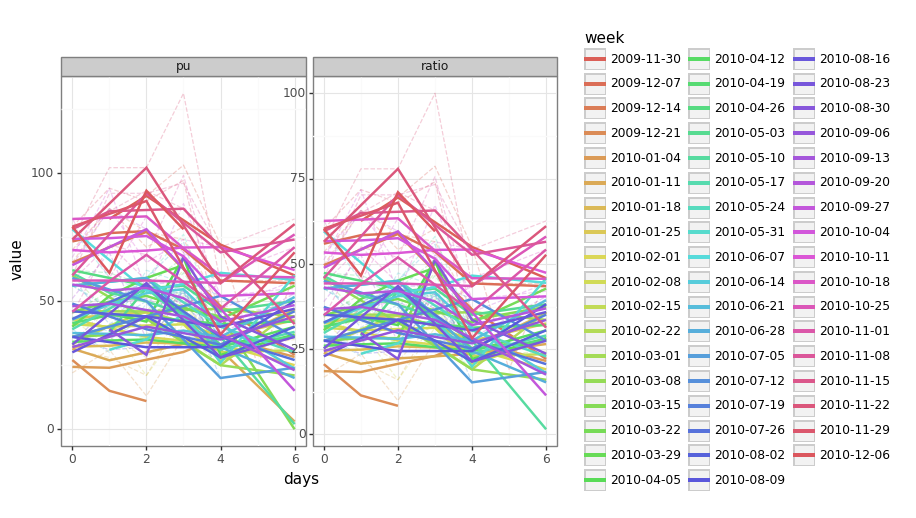

<ggplot: (8789714780313)>

In [49]:
(
    ggplot(df_, aes('days', 'value', color = 'week')) +
    gg.geom_line(alpha = .3, linetype = 'dashed') +
    gg.geom_smooth(se = False) + 
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [50]:
mat = [list('ABC'), list('DEF'), list('GHI')]

for r, rows in enumerate(mat) :
  for c, letters in enumerate(rows) : 
    print(f'({r},{c})-{letters}')

(0,0)-A
(0,1)-B
(0,2)-C
(1,0)-D
(1,1)-E
(1,2)-F
(2,0)-G
(2,1)-H
(2,2)-I


In [51]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [54]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}